# In this code i wanna merge the Direct and Indirect Delivery and Plot it 

In [1]:
# Standard libraries
import os
import glob
import warnings
import gc

# Data manipulation and analysis libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import Dataset
# geopandas 
from shapely.geometry import Point
import geopandas as gpd

# Dask diagnostics and progress bar
from dask.diagnostics import ProgressBar

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import cartopy.crs as ccrs
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap

In [2]:
# Inputs
InDirect_dir = '/home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load'
Direct_dir = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/ZonalStats'

# Correct way to read CSV files
Direct_coastal = pd.read_csv(os.path.join(Direct_dir, 'DirectTNTP_CoastalWatershed_avg.csv'))
InDirect_coastal = pd.read_csv(os.path.join(InDirect_dir, 'InDirectedNP_CW_avg_23.csv'))

In [3]:
# outputs
out_dir_fig = '/home/abolmaal/modelling/FVCOM/Huron/figures'

In [4]:
Direct_coastal.columns

Index(['CW_Id', 'CW_Area', 'CoastalWatershedDirectTP_avg_kgday',
       'CoastalWatershedDirectTN_avg_grm2yr',
       'CoastalWatershedDirectTP_avg_grm2yr'],
      dtype='object')

In [5]:
InDirect_coastal.columns

Index(['time', 'group_id', 'particle_id', 'longitude', 'latitude', 'CW_Id',
       'CW_Area', 'TotalIndirectCW_TN_grm2yr', 'TotalIndirectCW_TP_grm2yr'],
      dtype='object')

In [7]:
#outputs 
out_dir = '/home/abolmaal/modelling/FVCOM/Huron/TotalNP'

In [8]:
# rename the column CW_Area to CW_Area_direct in Direct_coastal
Direct_coastal.rename(columns={'CW_Area': 'CW_Area_direct'}, inplace=True)

In [9]:
#rename the column CW_Area to CW_Area_indirect in InDirect_coastal
InDirect_coastal.rename(columns={'CW_Area': 'CW_Area_indirect'}, inplace=True)
InDirect_coastal.columns

Index(['time', 'group_id', 'particle_id', 'longitude', 'latitude', 'CW_Id',
       'CW_Area_indirect', 'TotalIndirectCW_TN_grm2yr',
       'TotalIndirectCW_TP_grm2yr'],
      dtype='object')

In [13]:
# print the length of InDirect_coastal
print(f'Length of InDirect_coastal: {len(Direct_coastal["CW_Id"])}')


Length of InDirect_coastal: 4249


In [14]:
# merge Direct and InDirect coastal data on CW_Id column
merged_coastal = pd.merge(Direct_coastal, InDirect_coastal, on='CW_Id', how='left',suffixes=('_direct', '_indirect'))


In [15]:
# Identify rows with any NaN values in the merged dataset
missing_rows = merged_coastal[merged_coastal.isnull().any(axis=1)]

# Print CW_Id values with missing data
missing_cw_ids = missing_rows['CW_Id'].unique()
print("CW_Id values with missing data after merge:")
print(missing_cw_ids)

CW_Id values with missing data after merge:
[   5    7    8 ... 4358 4360 4366]


In [16]:
merged_coastal

,CW_Id,CW_Area_direct,CoastalWatershedDirectTP_avg_kgday,CoastalWatershedDirectTN_avg_grm2yr,CoastalWatershedDirectTP_avg_grm2yr,time,group_id,particle_id,longitude,latitude,CW_Area_indirect,TotalIndirectCW_TN_grm2yr,TotalIndirectCW_TP_grm2yr
0,1,122693,0.113521,14.685401,0.337714,2023-07-12 00:00:00,16.0,16582307.0,-84.130340,45.564873,122693.0,0.252224,0.008351
1,2,1037015,0.113521,1.737483,0.039956,2023-07-12 00:00:00,16.0,16472307.0,-84.126320,45.556896,1037015.0,0.181743,0.006674
2,3,8404,0.001810,2.593307,0.078607,2023-03-04 06:00:00,3.0,3392303.0,-84.126434,45.553720,8404.0,0.527730,0.023327
3,4,189923,0.003057,0.184454,0.005874,2023-07-13 00:00:00,16.0,16432307.0,-84.126710,45.549454,189923.0,0.556432,0.021723
4,5,26892,0.113521,67.001184,1.540797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4244,4358,20191,0.113521,89.237574,2.052158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4245,4360,33652,0.113521,53.542014,1.231282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4246,4365,1683,0.113521,1070.585771,24.619794,2023-05-14 06:00:00,52.0,52092305.0,-82.454560,43.057620,1683.0,0.184196,0.004164
4247,4366,3365,0.113521,535.451962,12.313555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# change the order of the columns
merged_coastal = merged_coastal[['group_id','particle_id','CW_Id', 'CW_Area_direct','CW_Area_indirect' ,'CoastalWatershedDirectTN_avg_grm2yr', 'CoastalWatershedDirectTP_avg_grm2yr',
                                  'TotalIndirectCW_TN_grm2yr', 'TotalIndirectCW_TP_grm2yr','longitude', 'latitude']].copy()

In [18]:
merged_coastal.describe()

,group_id,particle_id,CW_Id,CW_Area_direct,CW_Area_indirect,CoastalWatershedDirectTN_avg_grm2yr,CoastalWatershedDirectTP_avg_grm2yr,TotalIndirectCW_TN_grm2yr,TotalIndirectCW_TP_grm2yr,longitude,latitude
count,1326.000000,1.326000e+03,4249.000000,4.249000e+03,1.326000e+03,4249.000000,4249.000000,1326.000000,1326.000000,1326.000000,1326.000000
mean,56.588989,5.691321e+07,2171.917392,3.826033e+05,9.346491e+05,467.338967,12.223634,2.547030,0.082802,-83.446789,44.119876
std,40.282671,4.027422e+07,1259.119616,3.749744e+06,6.455633e+06,6873.654007,203.105685,11.258362,0.384748,0.366099,0.570166
min,0.000000,4.023020e+05,1.000000,1.681000e+03,1.681000e+03,0.000728,0.000022,0.000008,0.000001,-84.130340,43.016730
25%,23.000000,2.305481e+07,1068.000000,5.045000e+03,2.017525e+04,17.273306,0.403949,0.066616,0.001819,-83.670286,43.759242
50%,39.000000,3.970231e+07,2181.000000,1.850000e+04,6.726800e+04,82.379108,1.894436,0.281565,0.007782,-83.450617,43.880991
75%,85.000000,8.513231e+07,3260.000000,7.901000e+04,2.114878e+05,357.074089,8.211477,1.025958,0.029202,-83.338515,44.259600
max,162.000000,1.626323e+08,4367.000000,1.341016e+08,1.341016e+08,361177.802701,10835.083710,161.877347,5.514072,-82.426110,45.564873


In [19]:
# Step 2: Calculate total N and P loads (per row)
merged_coastal['TotalN(directindirect)_grm2yr'] = (
    merged_coastal['TotalIndirectCW_TN_grm2yr'] +
    merged_coastal['CoastalWatershedDirectTN_avg_grm2yr']
)

merged_coastal['TotalP(directindirect)_grm2yr'] = (
    merged_coastal['TotalIndirectCW_TP_grm2yr'] +
    merged_coastal['CoastalWatershedDirectTP_avg_grm2yr']
)




In [ ]:
# save the merged_coastal dataframe to a csv file
merged_coastal.to_csv(os.path.join(Direct_dir, 'Total_Direct_Indirect_Loads.csv'),
                             index=False)

In [20]:
# show median max and min of Annual_N and Annual_P
print("Median Total_N:", merged_coastal['TotalN(directindirect)_grm2yr'].median())
print("Max Total_N:", merged_coastal['TotalN(directindirect)_grm2yr'].max())
print("Min Total_N:", merged_coastal['TotalN(directindirect)_grm2yr'].min())
print("median Total_P:", merged_coastal['TotalP(directindirect)_grm2yr'].median())
print("Max Total_P:", merged_coastal['TotalP(directindirect)_grm2yr'].max())
print("Min Total_P:", merged_coastal['TotalP(directindirect)_grm2yr'].min())

Median Total_N: 23.965526391424284
Max Total_N: 226285.4918734299
Min Total_N: 0.0105889329351571
median Total_P: 0.5609015032903177
Max Total_P: 6114.774517844245
Min Total_P: 0.0005282514924770415


In [21]:
# prin tthe median, max and min of IndirectCW_TN_grm2yr and IndirectCW_TP_grm2yr
print("Median IndirectCW_TN_grm2yr:", merged_coastal['TotalIndirectCW_TN_grm2yr'].mean())
print("Max IndirectCW_TN_grm2yr:", merged_coastal['TotalIndirectCW_TN_grm2yr'].max())
print("Min IndirectCW_TN_grm2yr:", merged_coastal['TotalIndirectCW_TN_grm2yr'].min())
print("Median IndirectCW_TP_grm2yr:", merged_coastal['TotalIndirectCW_TP_grm2yr'].mean())
print("Max IndirectCW_TP_grm2yr:", merged_coastal['TotalIndirectCW_TP_grm2yr'].max())
print("Min IndirectCW_TP_grm2yr:", merged_coastal['TotalIndirectCW_TP_grm2yr'].min())


Median IndirectCW_TN_grm2yr: 2.547029613323073
Max IndirectCW_TN_grm2yr: 161.87734661308656
Min IndirectCW_TN_grm2yr: 7.919683697838178e-06
Median IndirectCW_TP_grm2yr: 0.0828017592001502
Max IndirectCW_TP_grm2yr: 5.514071569162749
Min IndirectCW_TP_grm2yr: 1.4995161126286308e-06


In [22]:
# print the min max and median of CoastalWatershedDirectTN_avg_grm2yr and CoastalWatershedDirectTP_avg_grm2yr
print("Median CoastalWatershedDirectTN_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTN_avg_grm2yr'].median())
print("Max CoastalWatershedDirectTN_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTN_avg_grm2yr'].max())
print("Min CoastalWatershedDirectTN_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTN_avg_grm2yr'].min())
# print the 35th, 50th and 75th percentile of CoastalWatershedDirectTP_avg_grm2yr
print("35th percentile CoastalWatershedDirectTP_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'].quantile(0.35))
print("50th percentile CoastalWatershedDirectTP_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'].quantile(0.50))
print("75th percentile CoastalWatershedDirectTP_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'].quantile(0.75))
# print the median, max and min of CoastalWatershedDirectTP_avg_gr

print("Median CoastalWatershedDirectTP_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'].median())
print("Max CoastalWatershedDirectTP_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'].max())
print("Min CoastalWatershedDirectTP_avg_grm2yr:", merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'].min())

Median CoastalWatershedDirectTN_avg_grm2yr: 82.37910810363647
Max CoastalWatershedDirectTN_avg_grm2yr: 361177.802700841
Min CoastalWatershedDirectTN_avg_grm2yr: 0.0007278322977044
35th percentile CoastalWatershedDirectTP_avg_grm2yr: 0.7951470683869051
50th percentile CoastalWatershedDirectTP_avg_grm2yr: 1.89443643624916
75th percentile CoastalWatershedDirectTP_avg_grm2yr: 8.211477156884982
Median CoastalWatershedDirectTP_avg_grm2yr: 1.89443643624916
Max CoastalWatershedDirectTP_avg_grm2yr: 10835.083709676404
Min CoastalWatershedDirectTP_avg_grm2yr: 2.227913879192334e-05


In [ ]:
# Step 1: Convert 'time' to datetime
merged_coastal['time'] = pd.to_datetime(merged_coastal['time'])

# Step 2: Extract month as 'YYYY-MM'
merged_coastal['month'] = merged_coastal['time'].dt.to_period('M').astype(str)

# show alll the unique months
print("Unique Months:", merged_coastal['month'].unique())

In [ ]:
import numpy as np

# Create log-transformed columns
merged_coastal['log_Indirect_TN'] = np.log1p(merged_coastal['TotalIndirectCW_TN_grm2yr'])
merged_coastal['log_Annual_N'] = np.log1p(merged_coastal['TotalIndirectCW_TN_grm2yr'])
merged_coastal['log_Indirect_TP'] = np.log1p(merged_coastal['IndirectCW_TP_grm2yr'])
merged_coastal['log_Annual_P'] = np.log1p(merged_coastal['Annual_P'])


In [ ]:
#save the merged_coastal dataframe to a csv file
merged_coastal.to_csv(os.path.join(Direct_dir, 'Total_Direct_Indirect_Loads.csv'),
                       index=False)

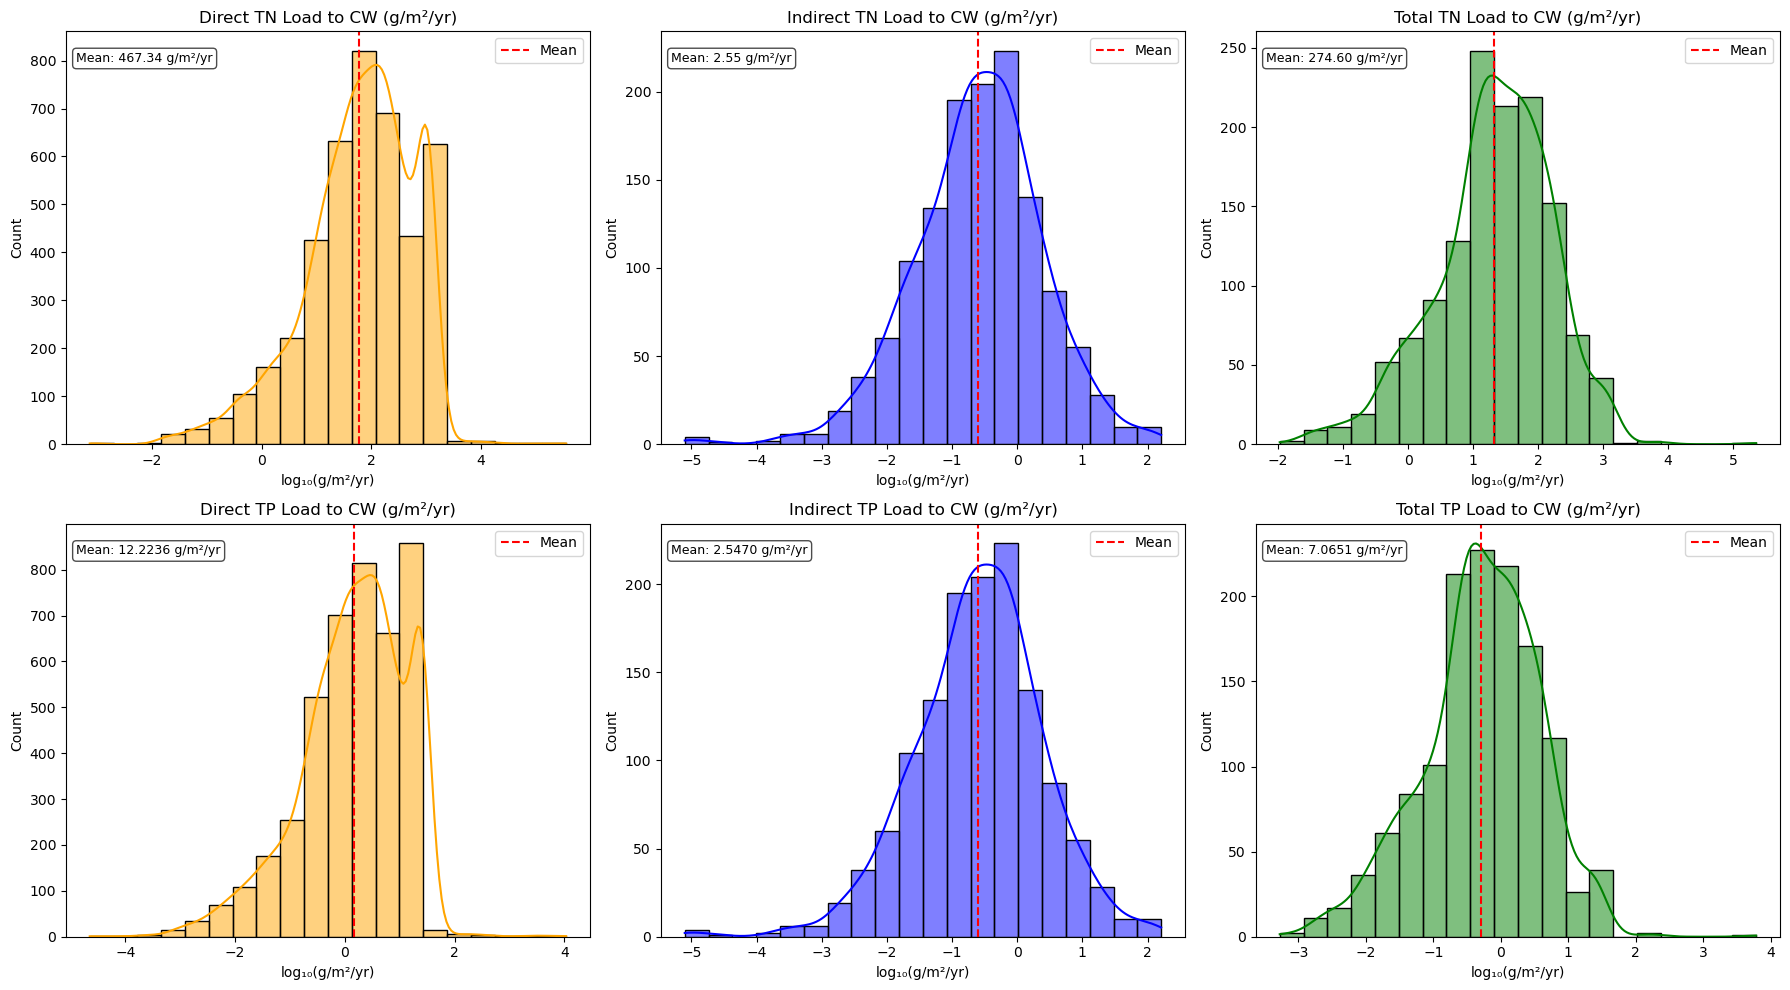

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# # Filter invalid values
# merged_coastal = merged_coastal[
#     (merged_coastal['TotalIndirectCW_TN_grm2yr'] > 0) &
#     (merged_coastal['TotalN(directindirect)_grm2yr'] > 0) &
#     (merged_coastal['TotalIndirectCW_TP_grm2yr'] > 0) &
#     (merged_coastal['TotalP(directindirect)_grm2yr'] > 0) &
#     (merged_coastal['CoastalWatershedDirectTN_avg_grm2yr'] > 0) &
#     (merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'] > 0)
# ]

# Log transform all nutrient metrics
merged_coastal['log10_Direct_TN'] = np.log10(merged_coastal['CoastalWatershedDirectTN_avg_grm2yr'])
merged_coastal['log10_Indirect_TN'] = np.log10(merged_coastal['TotalIndirectCW_TN_grm2yr'])
merged_coastal['log10_Annual_N'] = np.log10(merged_coastal['TotalN(directindirect)_grm2yr'])

merged_coastal['log10_Direct_TP'] = np.log10(merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'])
merged_coastal['log10_Indirect_TP'] = np.log10(merged_coastal['TotalIndirectCW_TN_grm2yr'])
merged_coastal['log10_Annual_P'] = np.log10(merged_coastal['TotalP(directindirect)_grm2yr'])

# Calculate means for annotations
avg_direct_N = merged_coastal['CoastalWatershedDirectTN_avg_grm2yr'].mean()
avg_indirect_N = merged_coastal['TotalIndirectCW_TN_grm2yr'].mean()
avg_total_N = merged_coastal['TotalN(directindirect)_grm2yr'].mean()

avg_direct_P = merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'].mean()
avg_indirect_P = merged_coastal['TotalIndirectCW_TN_grm2yr'].mean()
avg_total_P = merged_coastal['TotalP(directindirect)_grm2yr'].mean()

# Create 2x3 plot
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Row 1: Nitrogen
sns.histplot(merged_coastal['log10_Direct_TN'], kde=True, ax=axs[0, 0], color='orange', bins=20)
axs[0, 0].axvline(merged_coastal['log10_Direct_TN'].mean(), color='red', linestyle='--', label='Mean')
axs[0, 0].set_title('Direct TN Load to CW (g/m²/yr)')
axs[0, 0].set_xlabel('log₁₀(g/m²/yr)')
axs[0, 0].set_ylabel('Count')
axs[0, 0].text(0.02, 0.95, f"Mean: {avg_direct_N:.2f} g/m²/yr", transform=axs[0, 0].transAxes,
               fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axs[0, 0].legend()

sns.histplot(merged_coastal['log10_Indirect_TN'], kde=True, ax=axs[0, 1], color='blue', bins=20)
axs[0, 1].axvline(merged_coastal['log10_Indirect_TN'].mean(), color='red', linestyle='--', label='Mean')
axs[0, 1].set_title('Indirect TN Load to CW (g/m²/yr)')
axs[0, 1].set_xlabel('log₁₀(g/m²/yr)')
axs[0, 1].set_ylabel('Count')
axs[0, 1].text(0.02, 0.95, f"Mean: {avg_indirect_N:.2f} g/m²/yr", transform=axs[0, 1].transAxes,
               fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axs[0, 1].legend()

sns.histplot(merged_coastal['log10_Annual_N'], kde=True, ax=axs[0, 2], color='green', bins=20)
axs[0, 2].axvline(merged_coastal['log10_Annual_N'].mean(), color='red', linestyle='--', label='Mean')
axs[0, 2].set_title('Total TN Load to CW (g/m²/yr)')
axs[0, 2].set_xlabel('log₁₀(g/m²/yr)')
axs[0, 2].set_ylabel('Count')
axs[0, 2].text(0.02, 0.95, f"Mean: {avg_total_N:.2f} g/m²/yr", transform=axs[0, 2].transAxes,
               fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axs[0, 2].legend()

# Row 2: Phosphorus
sns.histplot(merged_coastal['log10_Direct_TP'], kde=True, ax=axs[1, 0], color='orange', bins=20)
axs[1, 0].axvline(merged_coastal['log10_Direct_TP'].mean(), color='red', linestyle='--', label='Mean')
axs[1, 0].set_title('Direct TP Load to CW (g/m²/yr)')
axs[1, 0].set_xlabel('log₁₀(g/m²/yr)')
axs[1, 0].set_ylabel('Count')
axs[1, 0].text(0.02, 0.95, f"Mean: {avg_direct_P:.4f} g/m²/yr", transform=axs[1, 0].transAxes,
               fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axs[1, 0].legend()

sns.histplot(merged_coastal['log10_Indirect_TP'], kde=True, ax=axs[1, 1], color='blue', bins=20)
axs[1, 1].axvline(merged_coastal['log10_Indirect_TP'].mean(), color='red', linestyle='--', label='Mean')
axs[1, 1].set_title('Indirect TP Load to CW (g/m²/yr)')
axs[1, 1].set_xlabel('log₁₀(g/m²/yr)')
axs[1, 1].set_ylabel('Count')
axs[1, 1].text(0.02, 0.95, f"Mean: {avg_indirect_P:.4f} g/m²/yr", transform=axs[1, 1].transAxes,
               fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axs[1, 1].legend()

sns.histplot(merged_coastal['log10_Annual_P'], kde=True, ax=axs[1, 2], color='green', bins=20)
axs[1, 2].axvline(merged_coastal['log10_Annual_P'].mean(), color='red', linestyle='--', label='Mean')
axs[1, 2].set_title('Total TP Load to CW (g/m²/yr)')
axs[1, 2].set_xlabel('log₁₀(g/m²/yr)')
axs[1, 2].set_ylabel('Count')
axs[1, 2].text(0.02, 0.95, f"Mean: {avg_total_P:.4f} g/m²/yr", transform=axs[1, 2].transAxes,
               fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axs[1, 2].legend()

plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, "Direct_Indirect_Total_TN_TP_CW_Log10.png"), dpi=300)
plt.show()


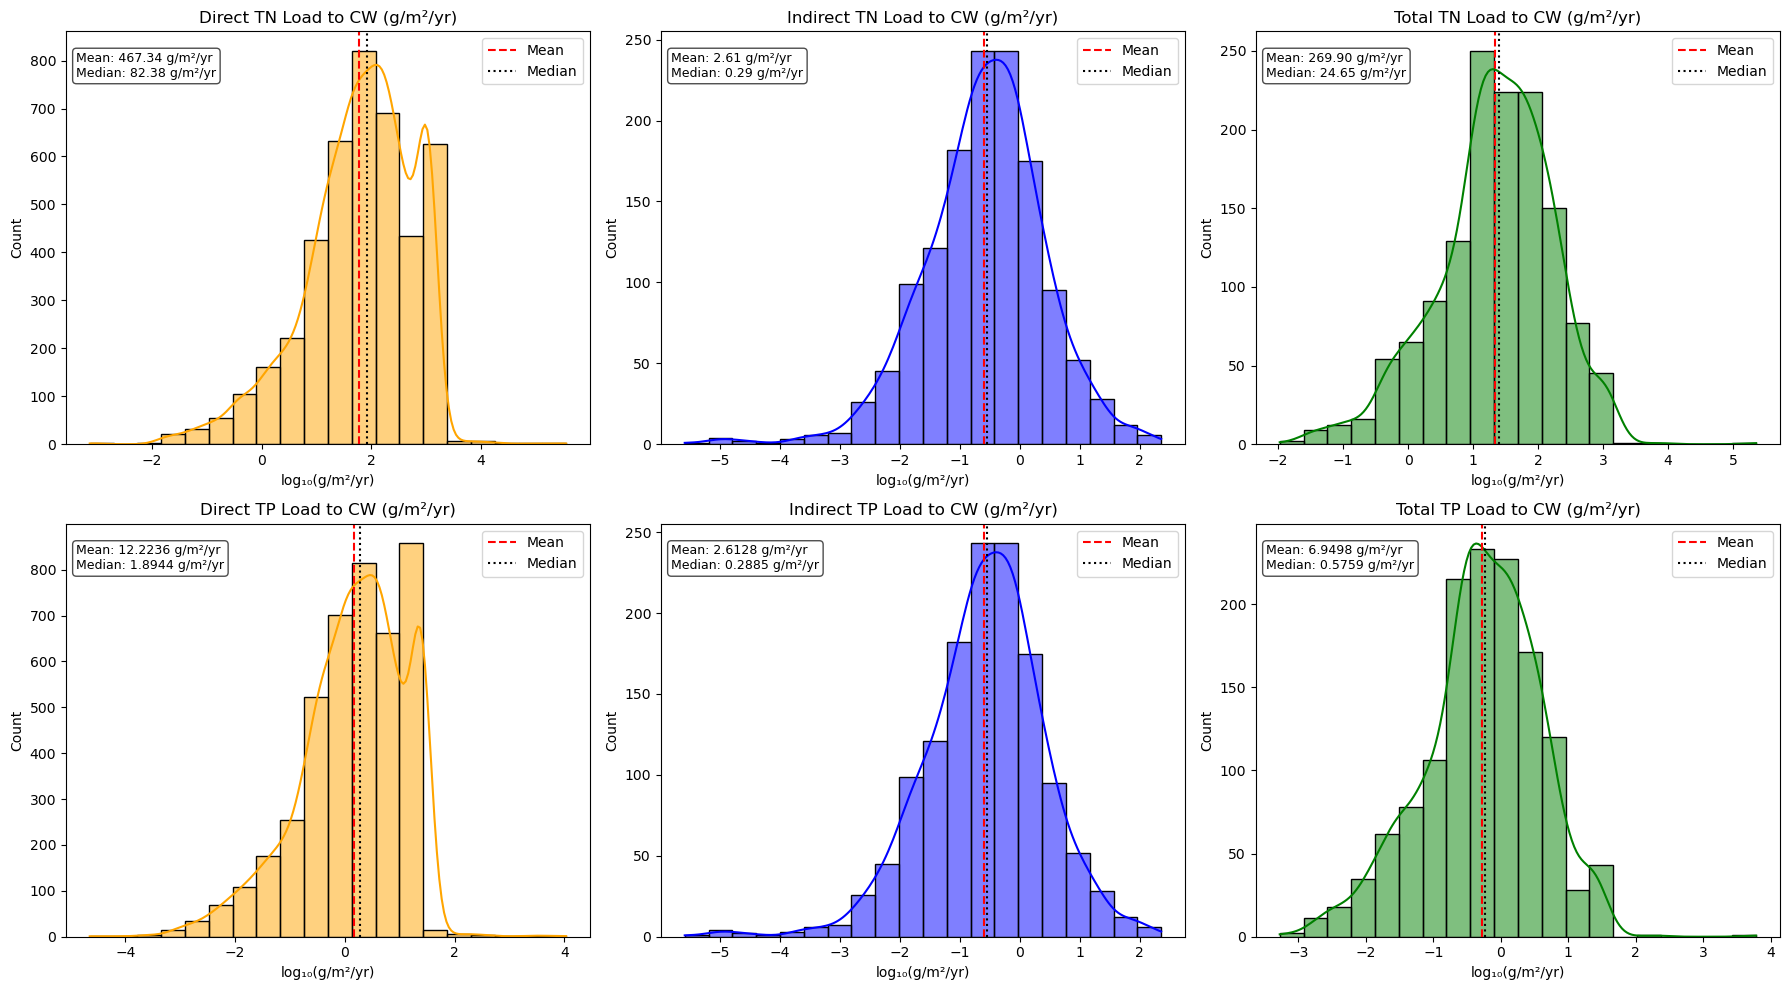

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Log transform all nutrient metrics
merged_coastal['log10_Direct_TN'] = np.log10(merged_coastal['CoastalWatershedDirectTN_avg_grm2yr'])
merged_coastal['log10_Indirect_TN'] = np.log10(merged_coastal['TotalIndirectCW_TN_grm2yr'])
merged_coastal['log10_Annual_N'] = np.log10(merged_coastal['TotalN(directindirect)_grm2yr'])

merged_coastal['log10_Direct_TP'] = np.log10(merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'])
merged_coastal['log10_Indirect_TP'] = np.log10(merged_coastal['TotalIndirectCW_TN_grm2yr'])
merged_coastal['log10_Annual_P'] = np.log10(merged_coastal['TotalP(directindirect)_grm2yr'])

# Calculate means
avg_direct_N = merged_coastal['CoastalWatershedDirectTN_avg_grm2yr'].mean()
avg_indirect_N = merged_coastal['TotalIndirectCW_TN_grm2yr'].mean()
avg_total_N = merged_coastal['TotalN(directindirect)_grm2yr'].mean()

avg_direct_P = merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'].mean()
avg_indirect_P = merged_coastal['TotalIndirectCW_TN_grm2yr'].mean()
avg_total_P = merged_coastal['TotalP(directindirect)_grm2yr'].mean()

# Calculate medians
median_direct_N = merged_coastal['CoastalWatershedDirectTN_avg_grm2yr'].median()
median_indirect_N = merged_coastal['TotalIndirectCW_TN_grm2yr'].median()
median_total_N = merged_coastal['TotalN(directindirect)_grm2yr'].median()

median_direct_P = merged_coastal['CoastalWatershedDirectTP_avg_grm2yr'].median()
median_indirect_P = merged_coastal['TotalIndirectCW_TN_grm2yr'].median()
median_total_P = merged_coastal['TotalP(directindirect)_grm2yr'].median()

# Log medians
log_median_direct_N = np.log10(median_direct_N)
log_median_indirect_N = np.log10(median_indirect_N)
log_median_total_N = np.log10(median_total_N)

log_median_direct_P = np.log10(median_direct_P)
log_median_indirect_P = np.log10(median_indirect_P)
log_median_total_P = np.log10(median_total_P)

# Create 2x3 plot
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# --- Row 1: TN ---
sns.histplot(merged_coastal['log10_Direct_TN'], kde=True, ax=axs[0, 0], color='orange', bins=20)
axs[0, 0].axvline(merged_coastal['log10_Direct_TN'].mean(), color='red', linestyle='--', label='Mean')
axs[0, 0].axvline(log_median_direct_N, color='black', linestyle=':', label='Median')
axs[0, 0].set_title('Direct TN Load to CW (g/m²/yr)')
axs[0, 0].set_xlabel('log₁₀(g/m²/yr)')
axs[0, 0].set_ylabel('Count')
axs[0, 0].text(0.02, 0.95, f"Mean: {avg_direct_N:.2f} g/m²/yr\nMedian: {median_direct_N:.2f} g/m²/yr",
               transform=axs[0, 0].transAxes, fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axs[0, 0].legend()

sns.histplot(merged_coastal['log10_Indirect_TN'], kde=True, ax=axs[0, 1], color='blue', bins=20)
axs[0, 1].axvline(merged_coastal['log10_Indirect_TN'].mean(), color='red', linestyle='--', label='Mean')
axs[0, 1].axvline(log_median_indirect_N, color='black', linestyle=':', label='Median')
axs[0, 1].set_title('Indirect TN Load to CW (g/m²/yr)')
axs[0, 1].set_xlabel('log₁₀(g/m²/yr)')
axs[0, 1].set_ylabel('Count')
axs[0, 1].text(0.02, 0.95, f"Mean: {avg_indirect_N:.2f} g/m²/yr\nMedian: {median_indirect_N:.2f} g/m²/yr",
               transform=axs[0, 1].transAxes, fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axs[0, 1].legend()

sns.histplot(merged_coastal['log10_Annual_N'], kde=True, ax=axs[0, 2], color='green', bins=20)
axs[0, 2].axvline(merged_coastal['log10_Annual_N'].mean(), color='red', linestyle='--', label='Mean')
axs[0, 2].axvline(log_median_total_N, color='black', linestyle=':', label='Median')
axs[0, 2].set_title('Total TN Load to CW (g/m²/yr)')
axs[0, 2].set_xlabel('log₁₀(g/m²/yr)')
axs[0, 2].set_ylabel('Count')
axs[0, 2].text(0.02, 0.95, f"Mean: {avg_total_N:.2f} g/m²/yr\nMedian: {median_total_N:.2f} g/m²/yr",
               transform=axs[0, 2].transAxes, fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axs[0, 2].legend()

# --- Row 2: TP ---
sns.histplot(merged_coastal['log10_Direct_TP'], kde=True, ax=axs[1, 0], color='orange', bins=20)
axs[1, 0].axvline(merged_coastal['log10_Direct_TP'].mean(), color='red', linestyle='--', label='Mean')
axs[1, 0].axvline(log_median_direct_P, color='black', linestyle=':', label='Median')
axs[1, 0].set_title('Direct TP Load to CW (g/m²/yr)')
axs[1, 0].set_xlabel('log₁₀(g/m²/yr)')
axs[1, 0].set_ylabel('Count')
axs[1, 0].text(0.02, 0.95, f"Mean: {avg_direct_P:.4f} g/m²/yr\nMedian: {median_direct_P:.4f} g/m²/yr",
               transform=axs[1, 0].transAxes, fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axs[1, 0].legend()

sns.histplot(merged_coastal['log10_Indirect_TP'], kde=True, ax=axs[1, 1], color='blue', bins=20)
axs[1, 1].axvline(merged_coastal['log10_Indirect_TP'].mean(), color='red', linestyle='--', label='Mean')
axs[1, 1].axvline(log_median_indirect_P, color='black', linestyle=':', label='Median')
axs[1, 1].set_title('Indirect TP Load to CW (g/m²/yr)')
axs[1, 1].set_xlabel('log₁₀(g/m²/yr)')
axs[1, 1].set_ylabel('Count')
axs[1, 1].text(0.02, 0.95, f"Mean: {avg_indirect_P:.4f} g/m²/yr\nMedian: {median_indirect_P:.4f} g/m²/yr",
               transform=axs[1, 1].transAxes, fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axs[1, 1].legend()

sns.histplot(merged_coastal['log10_Annual_P'], kde=True, ax=axs[1, 2], color='green', bins=20)
axs[1, 2].axvline(merged_coastal['log10_Annual_P'].mean(), color='red', linestyle='--', label='Mean')
axs[1, 2].axvline(log_median_total_P, color='black', linestyle=':', label='Median')
axs[1, 2].set_title('Total TP Load to CW (g/m²/yr)')
axs[1, 2].set_xlabel('log₁₀(g/m²/yr)')
axs[1, 2].set_ylabel('Count')
axs[1, 2].text(0.02, 0.95, f"Mean: {avg_total_P:.4f} g/m²/yr\nMedian: {median_total_P:.4f} g/m²/yr",
               transform=axs[1, 2].transAxes, fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
axs[1, 2].legend()

plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, "Direct_Indirect_Total_TN_TP_CW_Log10_with_median.png"), dpi=300)
plt.show()
